In [1]:
import numpy as np
import pandas as pd
from GENIE3 import *
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = np.load('../../data/oversampled_data.npy', allow_pickle=True)
gene = np.load('../../data/geneAfterDiscard_0.npy', allow_pickle=True)
select_gene_index = np.load('select_gene_index.npy') # index starts from 0.

feature = data[:, :-1]
label = data[:, -1]
print(gene.shape)
print(feature.shape)
print(label.shape)

(11959,)
(296, 11959)
(296,)


# Select the satisfactory gene.

In [3]:
ISGnum = 60

ISGfeature = feature[:, select_gene_index]
ISGgene_np = gene[select_gene_index]
ISGgene_list = ISGgene_np.tolist()

# Gaussian normalization and GENIE3

In [4]:
mean = ISGfeature.mean(axis = 0)
std = ISGfeature.std(axis = 0)
ISGfeature = ISGfeature - mean
ISGfeature = ISGfeature / std


# # Genes that are used as candidate regulators
# regulators = ['CD19', 'CDH17','RAD51','OSR2','TBX3']
# VIM2 = GENIE3(data,gene_names=gene_names,regulators=regulators)

VIM = GENIE3(ISGfeature, nthreads = 8) #data,tree_method=tree_method,K=K,ntrees=ntrees, 

get_link_list(VIM, gene_names=ISGgene_list, file_name='ranking.txt') # regulators=regulators,

Tree method: RF
K: sqrt
Number of trees: 1000


running jobs on 8 threads
Elapsed time: 16.78 seconds


In [5]:
relation_rank = pd.read_csv("ranking.txt", sep = "\t", header = None)
relation_rank

,0,1,2
0,CXCL11,WARS,0.149255
1,S1PR3,RPLP0P2,0.136925
2,WARS,CXCL11,0.135315
3,TPM1,STAC3,0.124738
4,ILDR1,RPLP0P2,0.108930
...,...,...,...
3535,TNFRSF14,CLSTN2,0.003433
3536,PRDX4,CLSTN2,0.003163
3537,ZC3H12A,RPLP0P2,0.003136
3538,DALRD3,RPLP0P2,0.002256


# Calculate the regulatory importance of genes.

In [6]:
weight = [0 for i in range(ISGnum)]

for i in relation_rank.index:
    weight[np.argwhere(ISGgene_np == relation_rank.iloc[i, 0])[0][0]] += relation_rank.iloc[i, 2]
    weight[np.argwhere(ISGgene_np == relation_rank.iloc[i, 1])[0][0]] += relation_rank.iloc[i, 2]

weight = np.array(weight)
weight

array([2.056388, 1.98074 , 2.407903, 2.1939  , 1.860655, 1.838643,
       1.967284, 1.908281, 2.111482, 2.27824 , 2.063145, 1.919757,
       1.764567, 1.921506, 1.92645 , 2.073131, 1.81202 , 2.126654,
       1.78002 , 2.180022, 2.143053, 1.999313, 1.86449 , 2.284137,
       2.225371, 1.969624, 1.880308, 2.155303, 1.847685, 2.385915,
       1.695552, 1.940027, 1.894855, 2.339803, 2.358297, 1.795667,
       1.824362, 1.930587, 1.768637, 1.879998, 2.053593, 1.900598,
       1.799982, 1.831491, 1.70976 , 1.782318, 1.948969, 1.973379,
       1.800367, 1.838838, 2.05076 , 1.807802, 1.990421, 2.061646,
       2.227273, 2.28022 , 2.023129, 2.358699, 2.085417, 1.798536])

# Genes are sorted in ascending order according to regulatory importance.

In [7]:
order_idx = np.argsort(weight)

order_gene = ISGgene_np[order_idx]
np.savetxt('genie3_order_gene.txt', np.c_[order_gene], fmt='%s',delimiter='\t')
order_gene

array(['KRT7', 'SDCCAG8', 'CDKN2B', 'PEMT', 'DLST', 'ZNF175', 'IRAK4',
       'AARS', 'ZC3H12A', 'PNPLA6', 'KRT23', 'HDAC1', 'THAP10', 'OSCAR',
       'DALRD3', 'STOML2', 'HOMEZ', 'SHROOM3', 'ANLN', 'CDKAL1', 'ABHD13',
       'CXCL11', 'RPLP0P2', 'MACC1', 'AIMP2', 'TNFRSF14', 'CLSTN2',
       'KRI1', 'WARS', 'STAC3', 'ADAMTSL5', 'SLC19A2', 'RNF144B',
       'SLC35C1', 'ESR1', 'SNPH', 'TRIB3', 'DOT1L', 'ALKBH8', 'CDC16',
       'S1PR3', 'GDF11', 'ORMDL2', 'MRPS24', 'EI24', 'SDK1', 'ADCK5',
       'TPM1', 'PRDX4', 'TMEM14C', 'PPT2', 'CUL9', 'GLUL', 'EXOSC8',
       'RPF2', 'GARS', 'ITGA4', 'ILDR1', 'WNK2', 'SEC61G'], dtype=object)

In [8]:
feature_after_GENIE3 = ISGfeature[:, order_idx] # final_gene_num
feature_after_GENIE3.shape

(296, 60)

# Run the feature elimination algorithm.

In [9]:
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [11]:
reserved_gene_idx = []
alternative_gene_idx = [i for i in range(order_gene.shape[0])]

init_acc = 0

geneNum = []
acc = []
prec = []
rec = []
auc = []

times = order_gene.shape[0]

# train-test split    random_state=2022
X_train, X_test, y_train, y_test = train_test_split(feature_after_GENIE3, label, test_size=0.3, shuffle=True, random_state=2022)

for i in range(times):
    
    geneNum.append(i + 1)
    reserved_gene_idx += [alternative_gene_idx[i]]
    
    xTrain = X_train[:, np.array(reserved_gene_idx)]
    xTest = X_test[:, np.array(reserved_gene_idx)]

    allAcc = []
    allPrec = []
    allRec = []
    allAuc = []
    
    for _ in range(5):
        rf = RandomForestClassifier()
        rf.fit(xTrain, y_train)  
        y_pred = rf.predict(xTest)
        
        allAcc.append(accuracy_score(y_test, y_pred))
        allPrec.append(precision_score(y_test, y_pred))
        allRec.append(recall_score(y_test, y_pred))
        predict_prob_y = rf.predict_proba(xTest)[:, 1]
        allAuc.append(roc_auc_score(y_test, predict_prob_y))

    if np.array(allAcc).mean() > init_acc:
        init_acc = np.array(allAcc).mean()
        
        acc.append(np.array(allAcc).mean())
        prec.append(np.array(allPrec).mean())
        rec.append(np.array(allRec).mean())
        auc.append(np.array(allAuc).mean())
    else:
        reserved_gene_idx.remove(alternative_gene_idx[i])
        
        
geneNum = np.array(geneNum)
acc = np.array(acc)
prec = np.array(prec)
rec = np.array(rec)
auc = np.array(auc)

feature_elimination_path = "performance/feature_elimination_genie3_asc_"

np.save(feature_elimination_path + "acc.npy", acc)
np.save(feature_elimination_path + "prec.npy", prec)
np.save(feature_elimination_path + "rec.npy", rec)
np.save(feature_elimination_path + "auc.npy", auc)

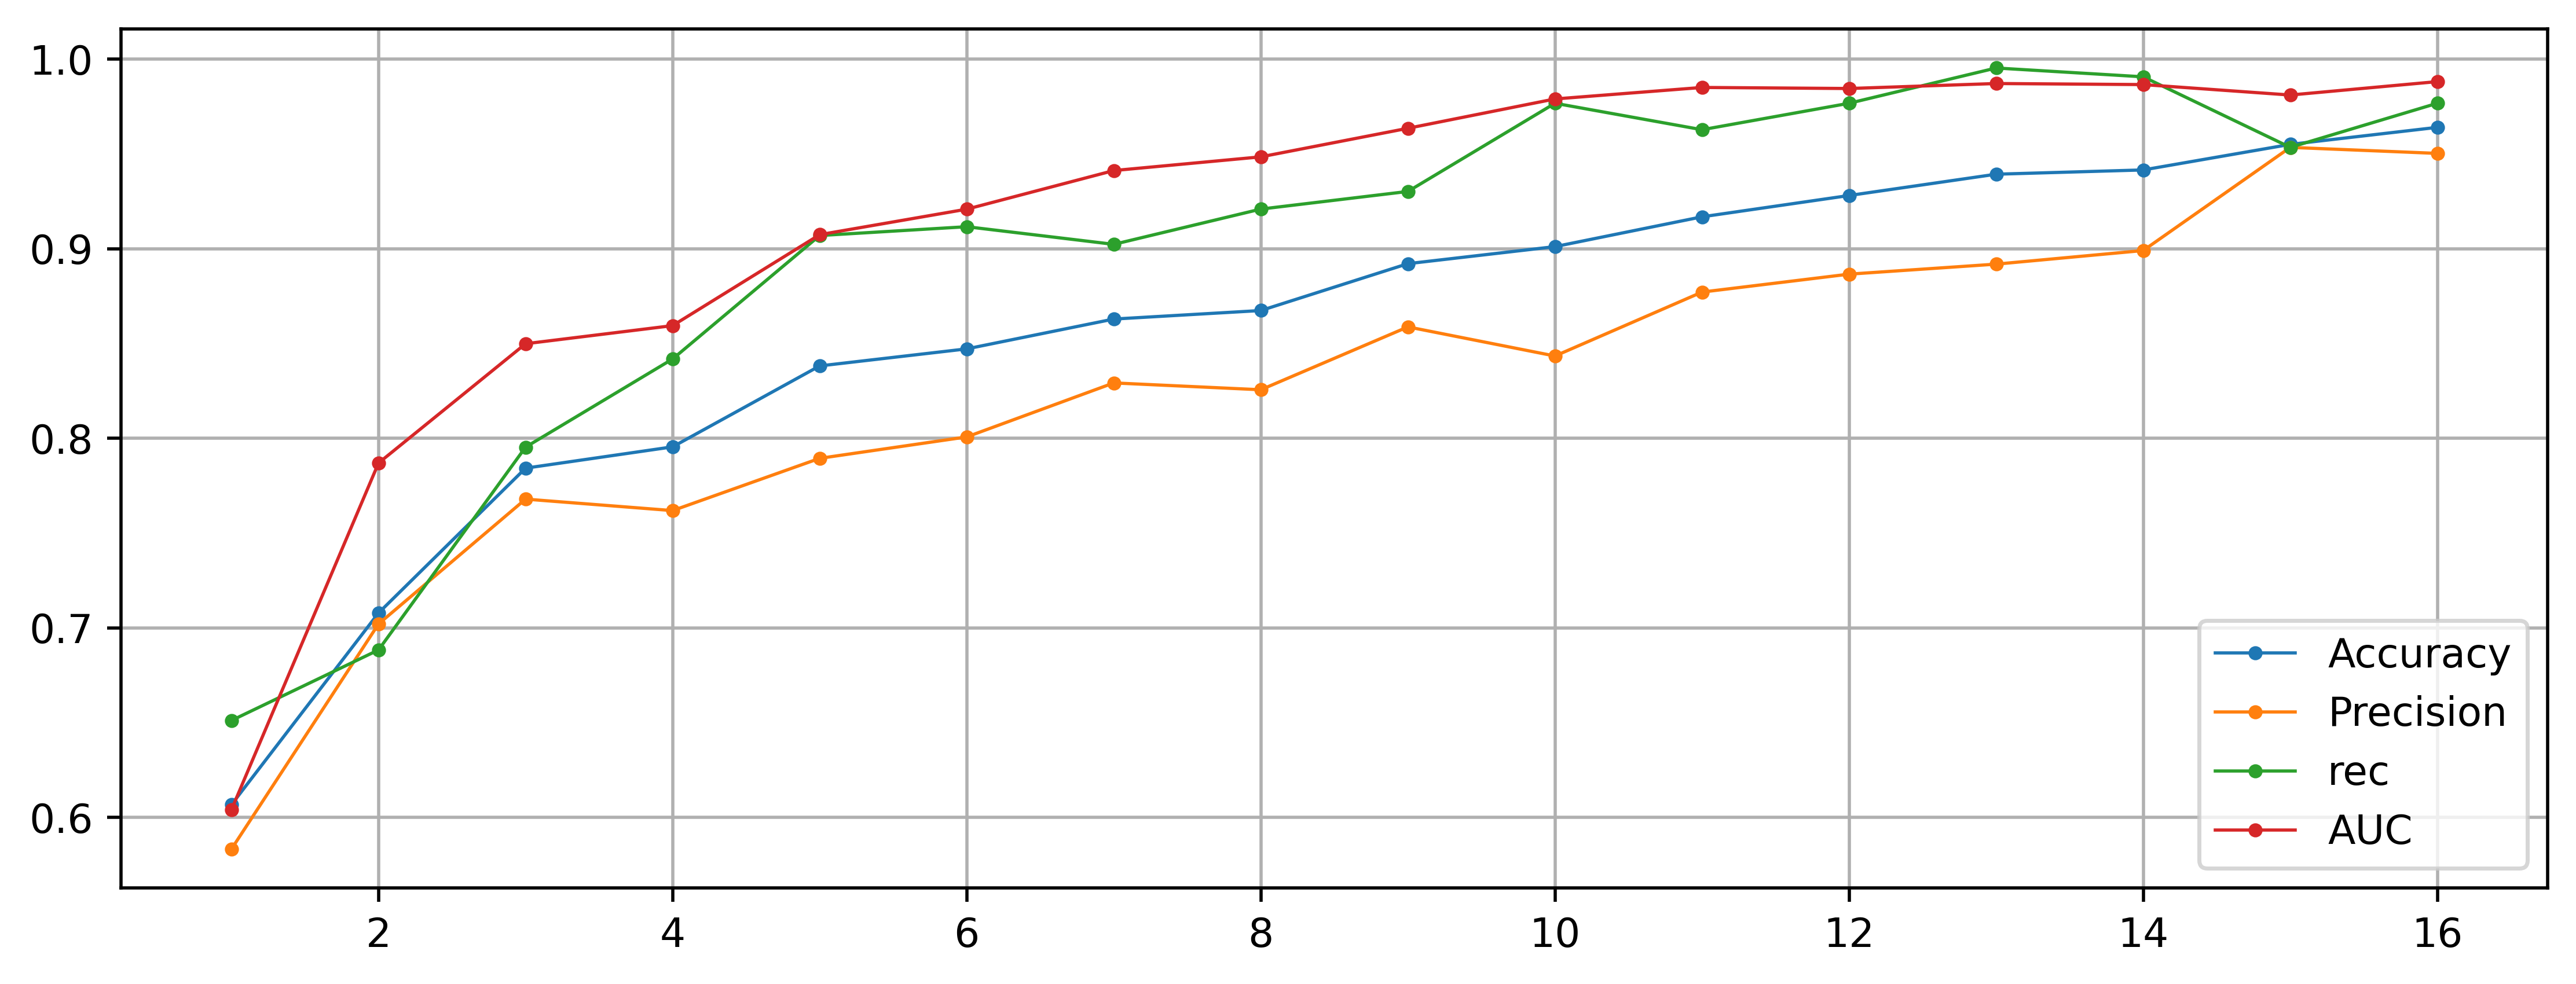

In [12]:
ISGnum = bar = len(acc)

pointnum = bar
x_axi = geneNum[:pointnum]
plt.figure(figsize=(9, 3.5), dpi=500)

markersize = 5
linewidth = 0.8

plt.plot(x_axi, acc[:pointnum], '.-',label='Accuracy', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, prec[:pointnum], '.-',label='Precision', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, rec[:pointnum], '.-',label='rec', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, auc[:pointnum], '.-',label='AUC', markersize= markersize, linewidth = linewidth)

plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

In [13]:
checkPoint = ISGnum - 1
print('{}\t{}\t{}\t{}\t{}'.format(ISGnum, acc[checkPoint], prec[checkPoint], rec[checkPoint],  auc[checkPoint]))

16	0.9640449438202248	0.9503030303030304	0.9767441860465116	0.988169868554095
